In [1]:
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

2024-08-26 16:18:34.892242: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Input shape: [18]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Minimum Validation Loss: 0.2006


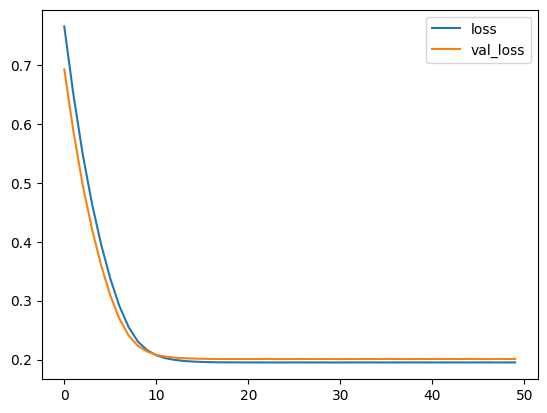

In [3]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Minimum Validation Loss: 0.2006


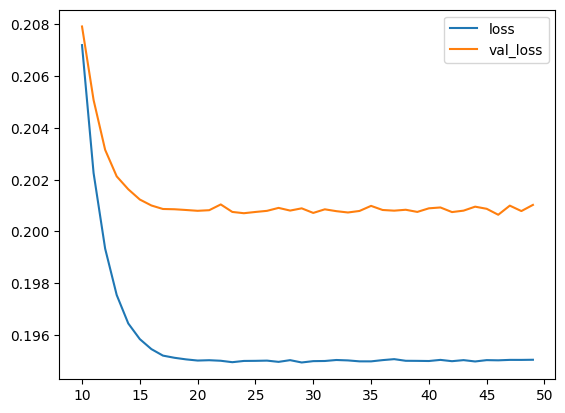

In [4]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2692 - val_loss: 0.2111
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2018 - val_loss: 0.2055
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1951 - val_loss: 0.2032
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1919 - val_loss: 0.2021
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1894 - val_loss: 0.2024
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1887 - val_loss: 0.2018
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1863 - val_loss: 0.2011
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1857 - val_loss: 0.2017
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1847 - val_loss: 0.2014
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1846 - val_loss: 0.2005
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1846 - val_loss: 0.2016
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1816 - val_loss: 0.2015


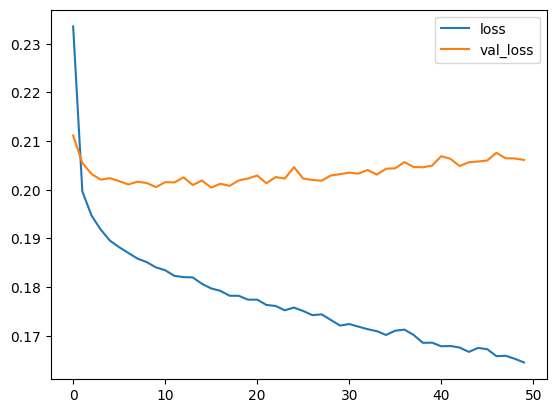

In [5]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [6]:
early_stopping = callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2759 - val_loss: 0.2110
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2023 - val_loss: 0.2057
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1967 - val_loss: 0.2023
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1921 - val_loss: 0.2024
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1888 - val_loss: 0.2010
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1880 - val_loss: 0.2020
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1850 - val_loss: 0.2010
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1847 - val_loss: 0.2031
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1832 - val_loss: 0.2020
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1847 - val_loss: 0.2019
Minimum Validation Loss: 0.2010


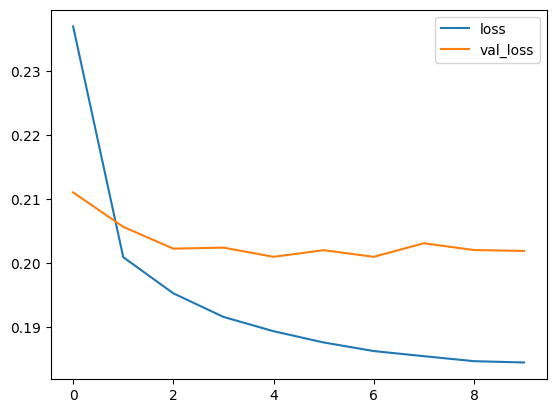

In [7]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));